# ABC calibration of $I_\text{CaL}$ in standardised model to unified dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.29.1


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Li1997]
 - Activation time constant [Li1997]
 - Steady-state inactivation [Li1997]
 - Inactivation time constant (fast+slow) [Li1997]
 - Recovery time constant (fast+slow) [Li1997]

In [4]:
from experiments.ical_li import (li_act_and_tau,
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

In [5]:
modelfile = 'models/standardised_ical.mmt'

Plot steady-state and tau functions of original model (pretty much meaningless for standardised)

In [6]:
from ionchannelABC.visualization import plot_variables

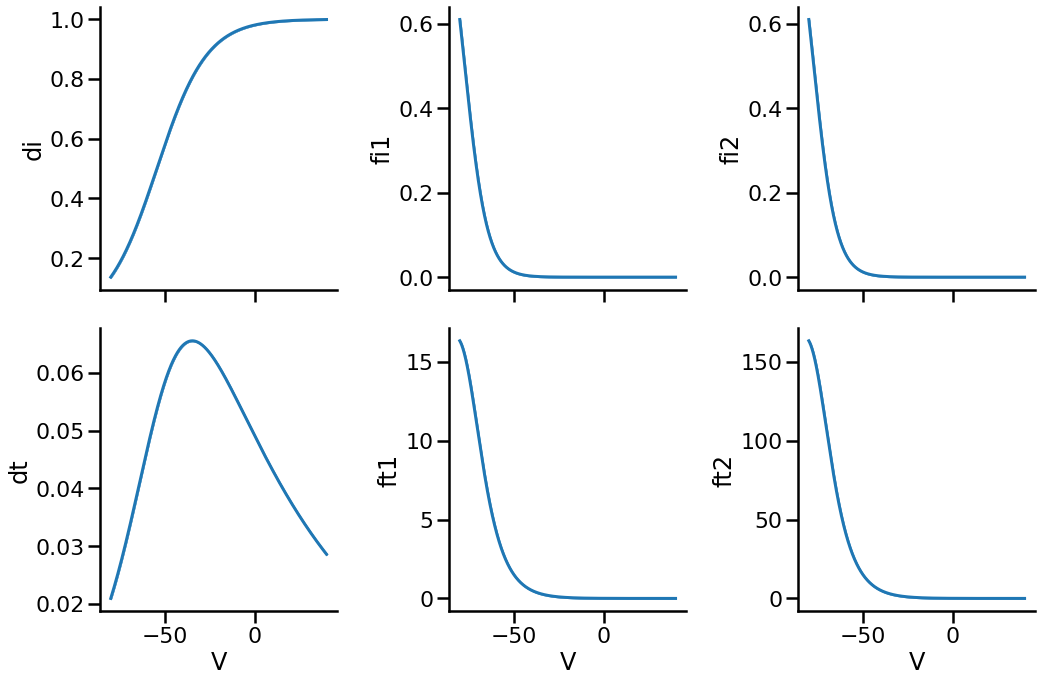

In [7]:
sns.set_context('poster')

V = np.arange(-80, 40, 0.01)

sta_par_map = {'di': 'ical.d_ss',
            'fi1': 'ical.f_ss',
            'fi2': 'ical.f_ss',
            'dt':  'ical.tau_d',
            'ft1': 'ical.tau_f1',
            'ft2': 'ical.tau_f2'}

f, ax = plot_variables(V, sta_par_map, 'models/standardised_ical.mmt', figshape=(3,2))

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [10]:
limits = {'log_ical.p_1': (-7, 3),
          'ical.p_2': (1e-7, 0.4),
          'log_ical.p_3': (-7, 3),
          'ical.p_4': (1e-7, 0.4),
          'log_ical.p_5': (-7, 3),
          'ical.p_6': (1e-7, 0.4),
          'log_ical.p_7': (-7, 3),
          'ical.p_8': (1e-7, 0.4),
          'log_ical.A': (0., 3.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [11]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "standardised_ical.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [13]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 512 particles


In [14]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9678753977594495, '1': 0.9678753977594495, '2': 0.9678753977594495, '3': 0.9678753977594495, '4': 0.9678753977594495, '5': 0.9678753977594495, '6': 0.9678753977594495, '7': 0.8108388442136876, '8': 0.4949276062083544, '9': 0.40434403902433114, '10': 0.3182415505473346, '11': 0.32995173747223605, '12': 0.4054194221068438, '13': 0.9678753977594495, '14': 0.9678753977594495, '15': 0.9678753977594495, '16': 0.948320343641584, '17': 1.106143311725085, '18': 1.106143311725085, '19': 1.106143311725085, '20': 1.106143311725085, '21': 0.3661134182449056, '22': 0.5684392546434062, '23': 0.7593993167501771, '24': 0.9437195392623547, '25': 1.106143311725085, '26': 1.106143311725085, '27': 1.106143311725085, '28': 1.0340756653619416, '29': 0.9437195392623547, '30': 0.7095117703943247, '31': 0.5182027705336358, '32': 0.47053527060396244, '33': 0.4147752932240028, '34': 0.47137080052372676, '35': 0.24685138829306388, '36': 0.5737108704898386, '37': 0.86131728575

In [15]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-18 06:53:49.521309, end_time=None)>


In [17]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 100.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 36763.
INFO:ABC:Acceptance rate: 2000 / 36763 = 5.4403e-02.
DEBUG:Epsilon:new eps, t=1, eps=5.922680476899402
INFO:ABC:t: 1, eps: 5.922680476899402.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 44104.
INFO:ABC:Acceptance rate: 2000 / 7341 = 2.7244e-01.
DEBUG:Epsilon:new eps, t=2, eps=3.2952352491183308
INFO:ABC:t: 2, eps: 3.2952352491183308.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 51473.
INFO:ABC:Acceptance rate: 2000 / 7369 = 2.7141e-01.
DEBUG:Epsilon:new eps, t=3, eps=2.905564613074698
INFO:ABC:t: 3, eps: 2.905564613074698.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 61115.
INFO:ABC:Acceptance rate: 2000 / 9642 = 2.0743e-01.
DEBUG:Epsilon:new eps, t=4, eps=2.735871344074876

INFO:ABC:Acceptance rate: 2000 / 144242 = 1.3866e-02.
DEBUG:Epsilon:new eps, t=32, eps=0.9628333449727358
INFO:ABC:t: 32, eps: 0.9628333449727358.
DEBUG:ABC:Now submitting population 32.
DEBUG:ABC:Population 32 done.
DEBUG:ABC:Total samples up to t = 32: 1710119.
INFO:ABC:Acceptance rate: 2000 / 196986 = 1.0153e-02.
DEBUG:Epsilon:new eps, t=33, eps=0.9500824170949524
INFO:ABC:t: 33, eps: 0.9500824170949524.
DEBUG:ABC:Now submitting population 33.
DEBUG:ABC:Population 33 done.
DEBUG:ABC:Total samples up to t = 33: 1950395.
INFO:ABC:Acceptance rate: 2000 / 240276 = 8.3238e-03.
DEBUG:Epsilon:new eps, t=34, eps=0.9389128378262751
INFO:History:Done <ABCSMC(id=1, start_time=2019-12-18 06:53:49.521309, end_time=2019-12-18 21:45:19.309757)>


In [18]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 34, eps: 0.9389128378262751.
DEBUG:ABC:Now submitting population 34.
DEBUG:ABC:Population 34 done.
DEBUG:ABC:Total samples up to t = 34: 2286381.
INFO:ABC:Acceptance rate: 2000 / 335986 = 5.9526e-03.
DEBUG:Epsilon:new eps, t=35, eps=0.9285486740085872
INFO:History:Done <ABCSMC(id=1, start_time=2019-12-18 06:53:49.521309, end_time=2019-12-18 23:34:08.004287)>


### Analysis of results

In [12]:
history = History(db_path)

In [13]:
df, w = history.get_distribution(m=0)

In [14]:
df.describe()

name,ical.p_2,ical.p_4,ical.p_6,ical.p_8,log_ical.A,log_ical.p_1,log_ical.p_3,log_ical.p_5,log_ical.p_7
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.019003,0.099080,0.047668,0.021136,0.793293,-2.457512,-0.252359,-1.084975,-1.644202
std,0.019013,0.061066,0.009094,0.006514,0.189340,2.487821,0.500666,0.208286,0.083896
min,0.000002,0.012383,0.022442,0.005650,0.499651,-6.991355,-2.251816,-1.395124,-1.946591
25%,0.005526,0.057206,0.040192,0.016167,0.608996,-5.089718,-0.651809,-1.218884,-1.705964
50%,0.011482,0.076454,0.049134,0.019903,0.800520,-1.944763,-0.048187,-1.142051,-1.631081
75%,0.025643,0.120369,0.054796,0.026022,0.888665,-0.112495,0.157008,-1.051480,-1.585458
max,0.084565,0.392057,0.068144,0.042126,1.323740,0.263695,0.424310,-0.442253,-1.332270


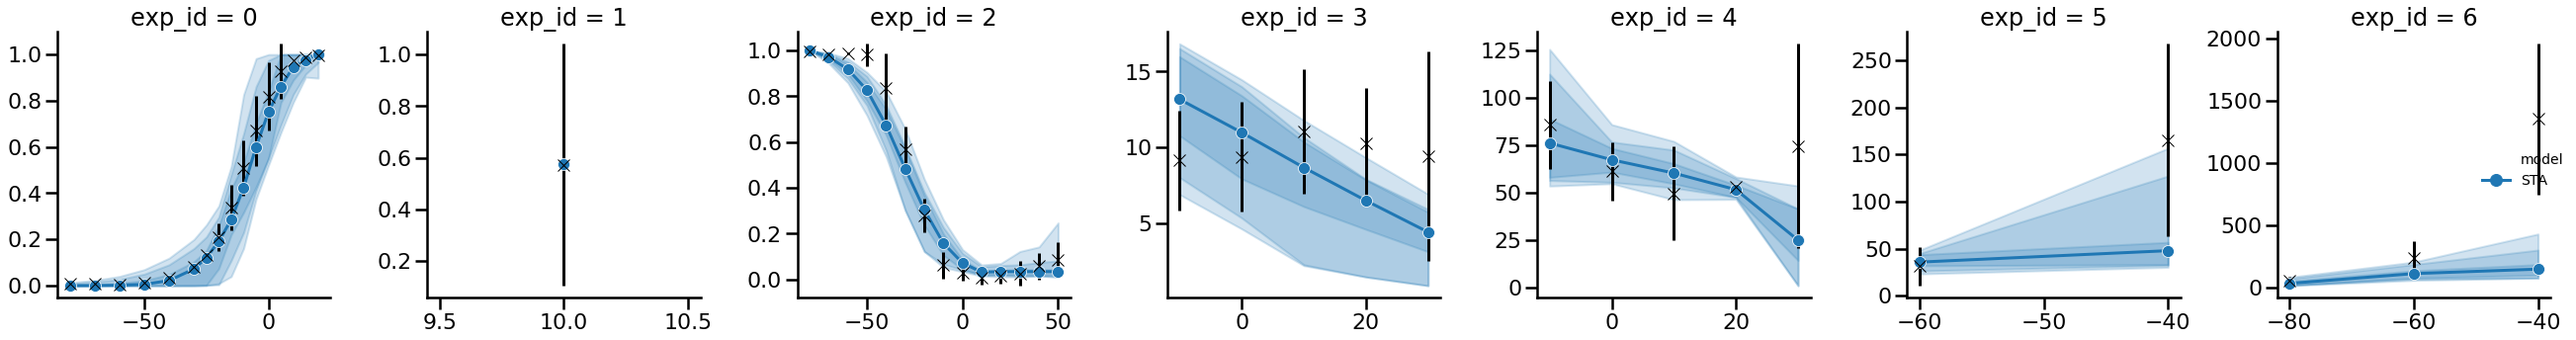

In [15]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14


g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     df=df, w=w)

plt.tight_layout()

In [16]:
import pandas as pd
N = 100
sta_par_samples = df.sample(n=N, weights=w, replace=True)
sta_par_samples = sta_par_samples.set_index([pd.Index(range(N))])
sta_par_samples = sta_par_samples.to_dict(orient='records')

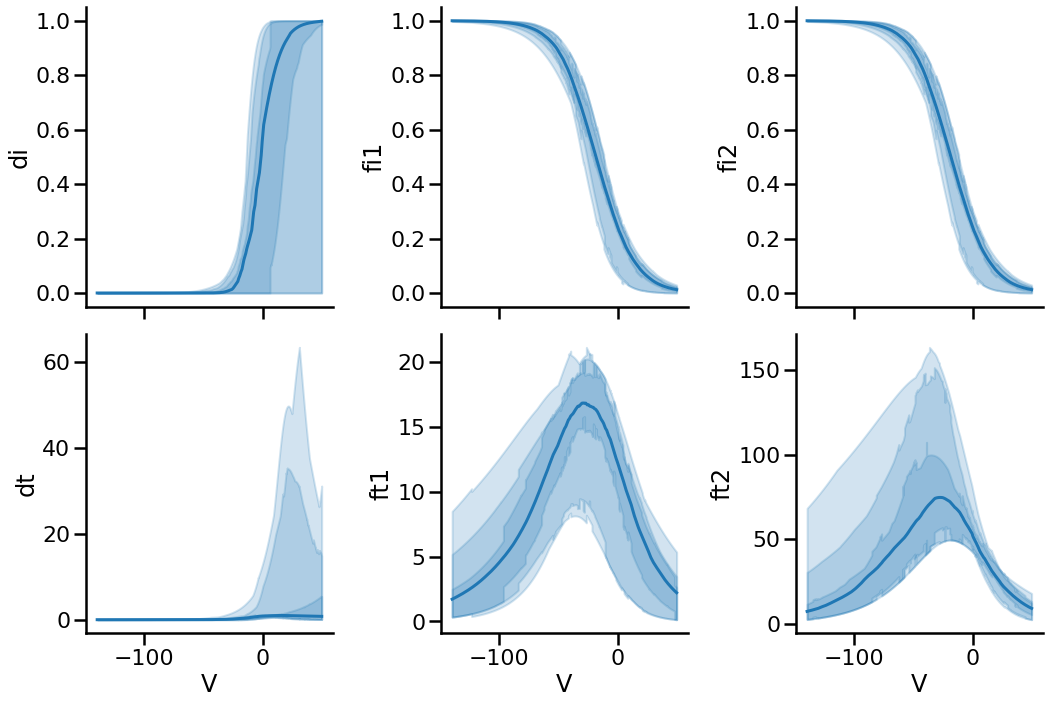

In [17]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

V = np.arange(-140, 50, 0.01)

sta_par_map = {'di': 'ical.d_ss',
               'fi1': 'ical.f_ss',
               'fi2': 'ical.f_ss',
               'dt': 'ical.tau_d',
               'ft1': 'ical.tau_f1',
               'ft2': 'ical.tau_f2'}

f, ax = plot_variables(V, sta_par_map, 
                       'models/standardised_ical.mmt', 
                       [sta_par_samples],
                       figshape=(3,2))

In [18]:
m,_,_ = myokit.load(modelfile)

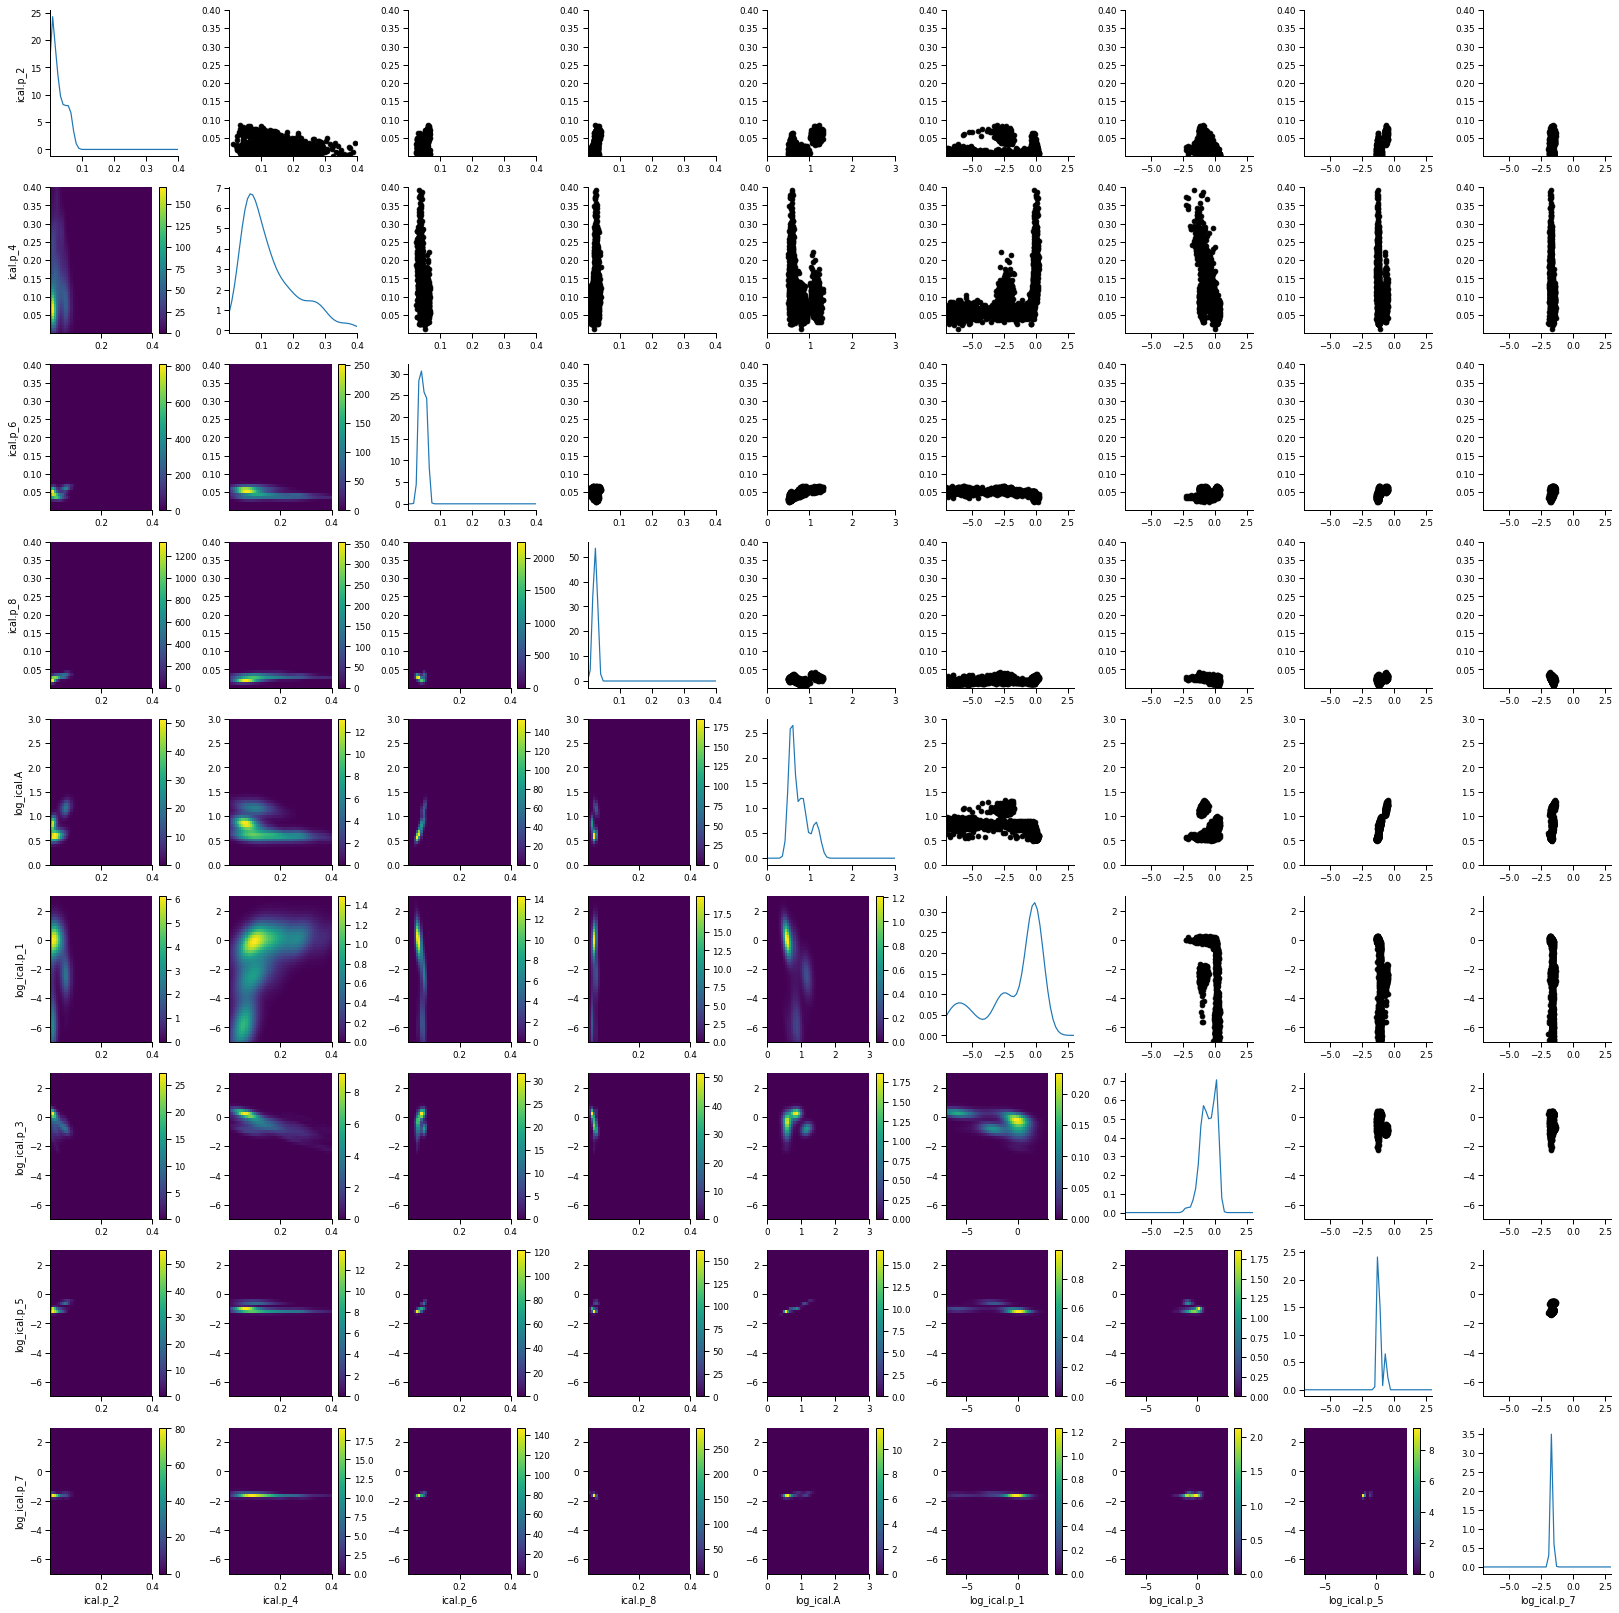

In [19]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits)
plt.tight_layout()